In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack 
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score, roc_auc_score

import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers  import Conv1D  
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers  import MaxPooling1D

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, GRU, SimpleRNN 

# DATASET PROCESSING

In [2]:
# load a single file as a numpy array
def load_file(filepath): 
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values 

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list() 
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
        
	# stack group so that features are the 3rd dimension
	loaded = np.concatenate(loaded)
	return loaded     

In [8]:
# load a dataset group, such as train or test
def load_dataset_group():
	filepath = "C:\\Users\\vvsat\\Documents\\machine learning\\gait parkinsons\\binary classification\\dataset\\dataset\\"
    
	# load all files as a single array
	filenames = list()
    
	filenames = ['test.txt'] 
    
	# load input data
	X = load_group(filenames, filepath)
    
    
	# load class output
	# load input data
	y = load_file("C:\\Users\\vvsat\\Documents\\machine learning\\gait parkinsons\\binary classification\\dataset\\dataset\\target_test.txt")
	return X, y

In [9]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    
	X, y = load_dataset_group()
	print(X.shape, y.shape) 
       
	# load all train
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=27) 
    
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
    
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
    
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

# MODEL BUILDING

In [10]:
# load data
trainX, trainy, testX, testy = load_dataset()
    
verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainy.shape[0]
print(n_timesteps, n_features, n_outputs)
   
print("trainX shape : ",trainX.shape) 
print("trainy shape : ",trainy.shape)  
    
#Build the LSTM model 
# LSTM Layer returns whole_seq_output, final_memory_state, and final_carry_state 
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(None, 1)))
model.add(GRU(128, return_sequences= True))
model.add(GRU(256, return_sequences= False))  
    
model.add(Dropout(rate = 0.5)) 
 
model.add(Dense(2)) 
model.summary()  

# learning rate decay
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile the model 
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  

(24238, 18) (24238, 1)
(18178, 18) (18178, 2) (6060, 18) (6060, 2)
18178 18 18178
trainX shape :  (18178, 18)
trainy shape :  (18178, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 64)          12864     
                                                                 
 gru_1 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_2 (GRU)                 (None, 256)               296448    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 384,322
Trainable params: 384,322
Non

   # TRAINING THE  MODEL  WITH GRU

In [7]:
#fitting the model  
history = model.fit(trainX, 
                    trainy, 
                    epochs=5,
                    batch_size=800,
                    validation_split=0.2,
                    verbose=1)           

Epoch 1/5
2489/2489 [==============================] - 48s 15ms/step - loss: 0.3580 - accuracy: 0.8362 - val_loss: 0.1553 - val_accuracy: 0.9402
Epoch 2/5
2489/2489 [==============================] - 38s 15ms/step - loss: 0.1092 - accuracy: 0.9593 - val_loss: 0.1216 - val_accuracy: 0.9540
Epoch 3/5
2489/2489 [==============================] - 37s 15ms/step - loss: 0.0726 - accuracy: 0.9735 - val_loss: 0.0642 - val_accuracy: 0.9762
Epoch 4/5
2489/2489 [==============================] - 38s 15ms/step - loss: 0.0571 - accuracy: 0.9790 - val_loss: 0.0571 - val_accuracy: 0.9790
Epoch 5/5
2489/2489 [==============================] - 38s 15ms/step - loss: 0.0489 - accuracy: 0.9820 - val_loss: 0.0497 - val_accuracy: 0.9817


# SAVING THE MODEL

In [8]:
model.save('binary_gru.h5') 

In [11]:
model = tf.keras.models.load_model('binary_gru_product.h5')

# PLOTTING THE METRICS

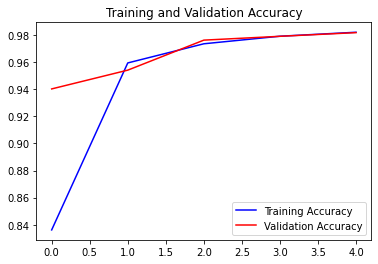

<Figure size 432x288 with 0 Axes>

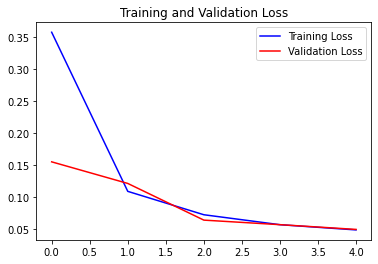

In [9]:
train_acc = history.history['accuracy'] 
train_loss = history.history['loss'] 
val_acc = history.history['val_accuracy'] 
val_loss = history.history['val_loss']

epochs = range(len(train_acc))  

plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

# MODEL EVALUATION

In [12]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(testX, testy, batch_size=800)
print("test loss, test acc:", results) 

Evaluate on test data
8/8 [==============================] - 10s 7ms/step - loss: 0.0269 - accuracy: 0.9909
test loss, test acc: [0.02687179483473301, 0.9909241199493408]


In [13]:
y_pred = model.predict(testX) 
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(testy, axis=1) 

In [14]:
print(y_pred)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

# CONFUSION MATRIX

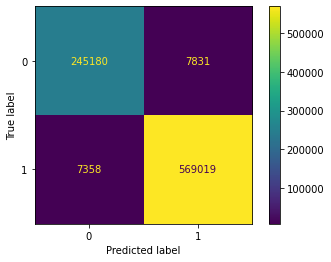

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() 

# DISPLAYING PRECISION, RECALL AND AUC

In [15]:
print('precision score : ', precision_score(y_test, y_pred, average = 'micro'),
      '\n', 'recall score : ', recall_score(y_test, y_pred, average = 'micro'))

precision score :  0.9816864965492629 
 recall score :  0.9816864965492629


In [30]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr) 
roc_auc

0.9781414132357368

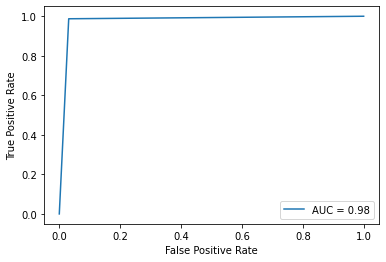

In [28]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()